In [54]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [55]:
def plot_conf_matrix(y_pred, y_true, title=None):
    """Helper Function to plot confustion matrix"""
    
    conf_mat = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Fake", "Real"]],
                  columns = [i for i in ["Fake", "Real"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if title:
        plt.title(f"{title} Confusion Matrix")
    plt.show()

# Read in Data and Preprocess

In [56]:
true_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/trueNews.csv")
fake_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/fakeNews.csv")
# Assign class columns and combine dataframes
fake_news_df["class"] = 1
true_news_df["class"] = 0
combined = pd.concat([fake_news_df, true_news_df], axis=0)

In [57]:
fake_news_df[fake_news_df["Text"].str.contains("Bill Gates is working")]["Text"].values
 # Bill Gates is working on an electronic chip to implant under human skin in order to locate and control people.\t\t

array([' Bill Gates is working on an electronic chip to implant under human skin in order to locate and control people.\t\t'],
      dtype=object)

In [58]:
true_news_df[true_news_df["Text"].str.contains("beyond recognition")]["Text"].values
# 'Covid-19 can damage lungs of victims beyond recognition, expert says  https://www.theguardian.com/world/2020/jun/15/covid-19-can-damage-lungs-victims-beyond-recognition-expert-says?utm_term=Autofeed&CMP=twt_b-gdnnews&utm_medium=Social&utm_source=Twitter#Echobox=1592245639\xa0'],

array(['Covid-19 can damage lungs of victims beyond recognition, expert says  https://www.theguardian.com/world/2020/jun/15/covid-19-can-damage-lungs-victims-beyond-recognition-expert-says?utm_term=Autofeed&CMP=twt_b-gdnnews&utm_medium=Social&utm_source=Twitter#Echobox=1592245639\xa0'],
      dtype=object)

In [59]:
# Subset data to just contain the text field and the class field
combined = combined[["Text", "class"]].reset_index(drop=True)
# Shuffle data
combined = combined.sample(frac = 1, random_state=42)

In [60]:
combined['Text'] = combined['Text'].str.replace('http\S+|www.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('pic\S+|twitter.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('#\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('@\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('Link:\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('[ \t]+$', '', case=False)
# remove front and ending blank spaces
combined = combined.replace({"^\s*|\s*$":""}, regex=True) 

def wordopt(text):
    """Formating of the text field """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    text = re.sub(' +', ' ', text)
    return text

combined["Text"] = combined["Text"].apply(wordopt)

In [61]:
combined[combined["class"]==1].iloc[1241]["Text"]

'the news media has tried to pass off one man s death attributed to complications from covid as two separate cases '

In [62]:
combined[combined["class"]==0].iloc[7]["Text"]

'show me the data u s doctors skeptical of reported covid breakthrough'

In [63]:
# for i in range(1000):
#     print(f"{i}: {combined[combined['class']==0].iloc[i]['Text']}")

In [64]:
combined[combined["class"]==0].iloc[540]["Text"]

''

In [65]:
combined[combined["class"]==1].iloc[540]["Text"]

'covid is a scripted narrative to justify closed borders or force residents to remain home '

In [66]:
combined.head()

,Text,class
5164,nhs nurse gets round of applause after recover...,0
6140,zali steggall increasingly concerned about mor...,0
1737,trump s claim that he imposed the first travel...,1
1446,says for otherwise healthy people experiencing...,1
586,a video shows an italian doctor who says that ...,1


In [67]:
# Set X and y variables
X = combined["Text"]
y = combined["class"]

In [68]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [69]:
X_train.shape[0]/combined.shape[0]

0.75

In [70]:
0.25*75

18.75

In [71]:
0.25*75

18.75

In [72]:
X_test.shape[0]/combined.shape[0]

0.25

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)

# Model 1: Naive Bayes Model

In [74]:
from sklearn.naive_bayes import MultinomialNB


nb_model = MultinomialNB()
# Fit model 
nb_model.fit(X_train, y_train)
# Predict 
y_pred = nb_model.predict(X_test)

In [75]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8929889298892989


In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       938
           1       0.90      0.89      0.89       959

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



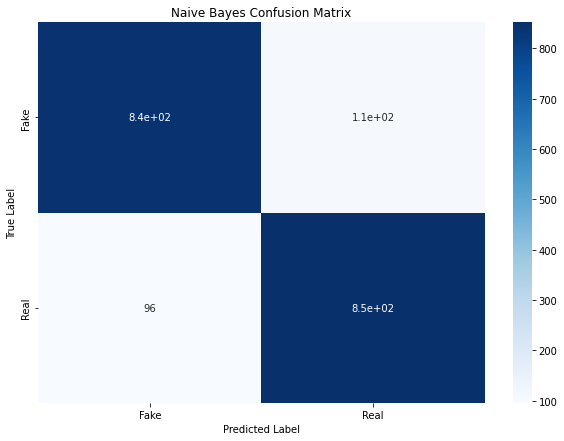

In [77]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

In [78]:
# 
params = {
    "alpha": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2, 3, 5, 10],
    "fit_prior": (True, False),
}
gs_clf = GridSearchCV(MultinomialNB(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [79]:
# gs_clf.cv_results_

In [80]:
y_pred = gs_clf.predict(X_test)

In [81]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

Test Accuracy: 0.889826041117554
Test Precision: 0.8972457627118644
Test Recall: 0.8832116788321168
Test f1 Score: 0.8901734104046244
Test roc auc score: 0.8899000824864209


In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       938
           1       0.90      0.88      0.89       959

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



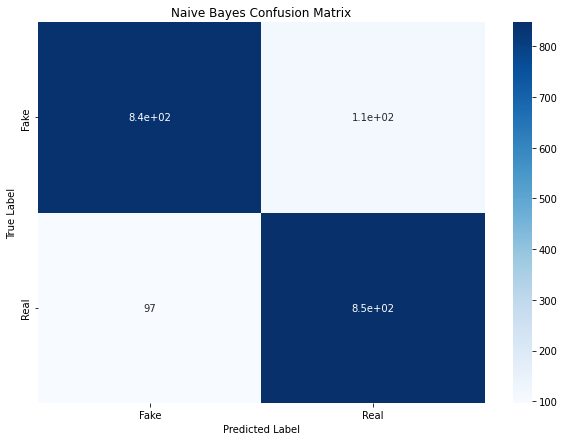

In [83]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

# Model 2: Gradient Boosting Classifier

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier()
# Fit model 
gbt_model.fit(X_train, y_train)
# Predict 
y_pred = gbt_model.predict(X_test)

In [85]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

Test Accuracy: 0.8518713758566157
Test Precision: 0.8783482142857143
Test Recall: 0.8206465067778936
Test f1 Score: 0.8485175202156335
Test roc auc score: 0.8522209079731686


In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       938
           1       0.88      0.82      0.85       959

    accuracy                           0.85      1897
   macro avg       0.85      0.85      0.85      1897
weighted avg       0.85      0.85      0.85      1897



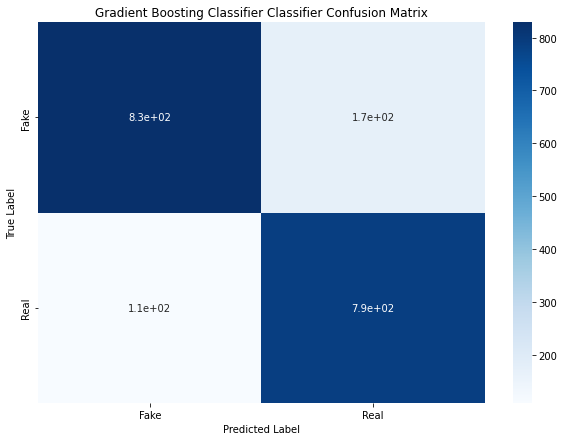

In [87]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

In [ ]:
%%time
params = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [0.001, 0.01, 0.1, 1, 2],
    "n_estimators": [10, 50, 100, 500],
    "subsample": [0.5, 0.75, 1.0],
}

gs_clf = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1, scoring='accuracy')
  
gs_clf = gs_clf.fit(X_train, y_train)
# Predict 
y_pred = gs_clf.predict(X_test)

In [ ]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

In [ ]:
print(classification_report(y_test, y_pred))

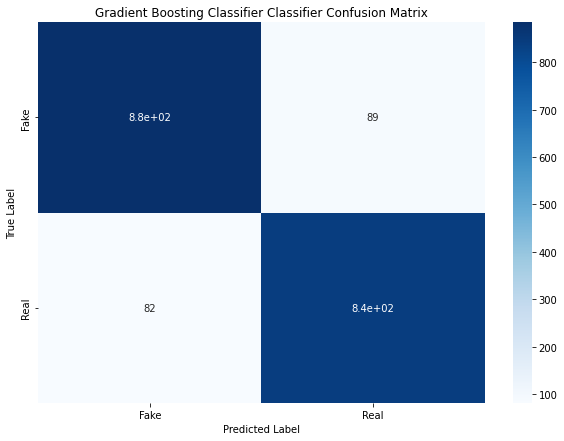

In [53]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

# Bidirectional LSTM 

In [38]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [40]:
X_train[:5]

array(['patrick jones a year old prisoner in louisiana who was serving a year prison term for a drug charge became the first federal inmate to die from covid ',
       'watch this report to know how physiotherapists are changing the way they function in post covid world dr saif naqvi ',
       'a year old youth who had travelled from delhi to chennai in a train tested positive for covid and is already in the isolation ward of rajiv gandhi government general hospital ',
       'french minister of justice did not threaten to sue the french journalist and tv host jean pierre pernaut after he criticized the government because of its way to deal with the epidemic ',
       'video of a burqa clad muslim woman being denied a food kit distributed to help people during the current crisis in india due to covid for being a muslim '],
      dtype=object)

In [41]:
max_tokens = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
encoder.adapt(X_train)

vocab_size = len(encoder.get_vocabulary())

2021-11-20 21:15:10.006631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 21:15:10.012548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 21:15:10.013209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 21:15:10.014276: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [42]:
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20]) # Sorted by frequency

['' '[UNK]' 'the' 'covid' 'in' 'to' 'of' 'a' 'and' 'coronavirus' 'for'
 'is' 'on' 'that' 's' 'with' 'from' 'has' 'are' 'cases']


In [43]:
X_train

array(['patrick jones a year old prisoner in louisiana who was serving a year prison term for a drug charge became the first federal inmate to die from covid ',
       'watch this report to know how physiotherapists are changing the way they function in post covid world dr saif naqvi ',
       'a year old youth who had travelled from delhi to chennai in a train tested positive for covid and is already in the isolation ward of rajiv gandhi government general hospital ',
       ...,
       'after spike in cases govt decided to quarantine patients at home while the decision is suitable for those living in houses which have multiple rooms it is not feasible for those residing in rooms in overcrowded slums ',
       'the health and economic crisis triggered by the covid pandemic has compounded the fiscal woes of the kerala government ',
       'the country on may registered a single day highest covid recovery so far of persons the rate being and the total number touched '],
      dtype=obje

In [44]:
encoded_egs = encoder(X_train)[:5].numpy()
print(X_train[0])
print(encoded_egs[0])

for i in range(5):
    print(f"Original: {X_train[i]}")
    print(f"Encoded-decoded: {' '.join(vocab[encoded_egs[i]])}\n")

patrick jones a year old prisoner in louisiana who was serving a year prison term for a drug charge became the first federal inmate to die from covid 
[3500    1    7  136  153 2022    4 3652   26   34 1417    7  136 1269
 1912   10    7  171 1828 1362    2  107 1054    1    5  356   16    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Original: patrick jones a year old prisoner in louisiana who was serving a year prison term for a drug charge became the first federal inmate to die from covid 
Encoded-decoded: patrick [UNK] a year old prisoner in louisiana who was serving a year prison term for a drug charge became the first federal [UNK] to die from covid                                                  

Original: watch this report to know how physiotherapists are changing the 

In [45]:
LSTM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=256,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0),
    tf.keras.layers.Dense(1)
])

In [46]:
vocab.shape

(5000,)

In [47]:
# LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
#               optimizer=tf.keras.optimizers.Adam(0.0005),
#               metrics=["accuracy"])

print(LSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 256)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              164352    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [48]:
vocab_size

5000

In [49]:
# Train multiple times and average out results

accuracies = []
precisions = []
recalls = []
f1s = []


runs = 10

max_tokens = None
encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
encoder.adapt(X_train)
vocab_size = len(encoder.get_vocabulary())
for i in range(runs):
    LSTM = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])
    history = LSTM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)
    y_pred = np.around(tf.math.sigmoid(LSTM.predict(X_test))).flatten()
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

Epoch 1/10


2021-11-20 21:15:24.930407: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2021-11-20 21:15:25.731444: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


67/67 [==============================] - 9s 39ms/step - loss: 0.6920 - accuracy: 0.5049 - val_loss: 0.6901 - val_accuracy: 0.4968
Epoch 2/10
67/67 [==============================] - 1s 12ms/step - loss: 0.6863 - accuracy: 0.5049 - val_loss: 0.6803 - val_accuracy: 0.4968
Epoch 3/10
67/67 [==============================] - 1s 12ms/step - loss: 0.6576 - accuracy: 0.5059 - val_loss: 0.6103 - val_accuracy: 0.5046
Epoch 4/10
67/67 [==============================] - 1s 13ms/step - loss: 0.4853 - accuracy: 0.6851 - val_loss: 0.4112 - val_accuracy: 0.8250
Epoch 5/10
67/67 [==============================] - 1s 13ms/step - loss: 0.3633 - accuracy: 0.8414 - val_loss: 0.3587 - val_accuracy: 0.8545
Epoch 6/10
67/67 [==============================] - 1s 14ms/step - loss: 0.2931 - accuracy: 0.8850 - val_loss: 0.3285 - val_accuracy: 0.8756
Epoch 7/10
67/67 [==============================] - 1s 13ms/step - loss: 0.2576 - accuracy: 0.9007 - val_loss: 0.3118 - val_accuracy: 0.8826
Epoch 8/10
67/67 [======

In [52]:
print(f"Test Accuracy: {np.array(accuracies).sum()/runs}")
print(f"Test Precision: {np.array(precisions).sum()/runs}")
print(f"Test Recall: {np.array(recalls).sum()/runs}")
print(f"Test F1 Score: {np.array(f1s).sum()/runs}")
# print(f"Test Precision: {precisions/runs}")
# print(f"Test Recall: {recall_score(y_test, y_pred)}")
# print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
# print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

Test Accuracy: 0.9032683183974697
Test Precision: 0.9163751519131755
Test Recall: 0.8925465838509317
Test F1 Score: 0.9038402298623336


In [53]:
f1s

[0.9093782929399368,
 0.8994551758296185,
 0.9019812304483839,
 0.9029810298102982,
 0.8998935037273695,
 0.9021852237252862,
 0.9066390041493776,
 0.9034300791556727,
 0.9094736842105263,
 0.9029850746268656]

In [63]:
y_pred = np.around(tf.math.sigmoid(LSTM.predict(X_test))).flatten()

In [39]:
y_pred

array([1., 1., 0., ..., 1., 1., 1.], dtype=float32)

In [40]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test f1 Score: {f1_score(y_test, y_pred)}")
print(f"Test roc auc score: {roc_auc_score(y_test, y_pred)}")

Test Accuracy: 0.8977332630469161
Test Precision: 0.9055201698513801
Test Recall: 0.8903966597077244
Test f1 Score: 0.8978947368421053
Test roc auc score: 0.8978074885333084


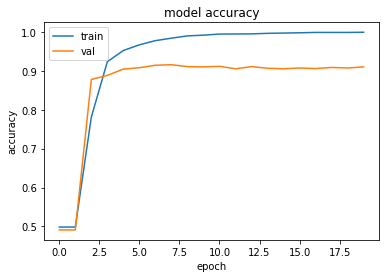

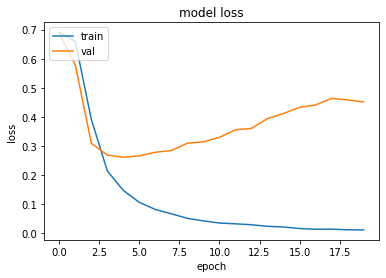

In [217]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="my-test-project", entity="tripleblackcat")

wandb: Currently logged in as: tripleblackcat (use `wandb login --relogin` to force relogin)


In [28]:
sweep_config = {
    "name": "b-lstm",
    "metric": {"name": "val_f1", "goal": "maximize"},
    "method": "random",
    "parameters": {
        "epochs": {"values": [10, 20, 40]},
        "lr": {"values": [0.005, 0.001, 0.0005, 0.0001]},
        "batch_size": {"values": [64, 128, 256]},
        "max_tokens": {"values": [100, 1000, 5000, None]},
        "embedding_dim": {"values": [16, 32, 64, 256]},
        "lstm_units": {"values": [16, 32, 64, 256]},
        "ff_size": {"values": [64, 128, 256]},
        "dropout": {"values": [0, 0.5]}
    }
}
def get_lstm(config, encoder, vocab_size):
    LSTM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=config.embedding_dim,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.lstm_units)),
    tf.keras.layers.Dense(config.ff_size, activation="relu"),
    tf.keras.layers.Dropout(config.dropout),
    tf.keras.layers.Dense(1)
    ])
    return LSTM

def sweep():
    with wandb.init() as run:
        config = wandb.config 

        max_tokens = config.max_tokens
        encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        encoder.adapt(X_train)

        vocab_size = len(encoder.get_vocabulary())

        lstm = get_lstm(config, encoder, vocab_size)
        lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                     optimizer=tf.keras.optimizers.Adam(config.lr),
                     metrics=["accuracy"])

        lstm.fit(X_train, 
                 y_train, 
                 validation_data=(X_val, y_val), 
                 epochs=config.epochs,
                 callbacks=[WandbCallback()])
       
        y_pred = np.around(tf.math.sigmoid(lstm.predict(X_test))).flatten()
        wandb.log({"val_f1": f1_score(y_test, y_pred)})
        del lstm

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, sweep, count=50)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: aoizs7rc
Sweep URL: https://wandb.ai/tripleblackcat/uncategorized/sweeps/aoizs7rc


wandb: Agent Starting Run: suf7xv23 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 40
wandb: 	ff_size: 64
wandb: 	lr: 0.0001
wandb: 	lstm_units: 64
wandb: 	max_tokens: 5000


Epoch 1/40


2021-11-20 17:04:30.640336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2021-11-20 17:04:31.467628: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


132/134 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5050

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd712b73250>]


134/134 [==============================] - 10s 22ms/step - loss: 0.6855 - accuracy: 0.5056 - val_loss: 0.6623 - val_accuracy: 0.4891
Epoch 2/40
134/134 [==============================] - 1s 11ms/step - loss: 0.4682 - accuracy: 0.7078 - val_loss: 0.3088 - val_accuracy: 0.8798
Epoch 3/40
134/134 [==============================] - 2s 12ms/step - loss: 0.2381 - accuracy: 0.9124 - val_loss: 0.2758 - val_accuracy: 0.9072
Epoch 4/40
134/134 [==============================] - 1s 11ms/step - loss: 0.1679 - accuracy: 0.9372 - val_loss: 0.2542 - val_accuracy: 0.9065
Epoch 5/40
134/134 [==============================] - 2s 12ms/step - loss: 0.1264 - accuracy: 0.9529 - val_loss: 0.2692 - val_accuracy: 0.9129
Epoch 6/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0948 - accuracy: 0.9667 - val_loss: 0.2638 - val_accuracy: 0.9108
Epoch 7/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0721 - accuracy: 0.9749 - val_loss: 0.2859 - val_accuracy: 0.9072
Epoch 8/4

accuracy,▁▄▇▇▇███████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████████████████████████
val_f1,▁
val_loss,█▂▁▁▁▁▂▂▂▂▆▃▃▄▄▃▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
accuracy,0.99977
best_epoch,3
best_val_loss,0.25417
epoch,39
loss,0.00139


wandb: Agent Starting Run: 2mf95d6n with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 1000


Epoch 1/10
131/134 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.8371

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5f45e3d00>]


134/134 [==============================] - 9s 26ms/step - loss: 0.3203 - accuracy: 0.8393 - val_loss: 0.2364 - val_accuracy: 0.8988
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.1732 - accuracy: 0.9304 - val_loss: 0.2447 - val_accuracy: 0.9122
Epoch 3/10
134/134 [==============================] - 2s 12ms/step - loss: 0.1190 - accuracy: 0.9522 - val_loss: 0.2502 - val_accuracy: 0.9009
Epoch 4/10
134/134 [==============================] - 2s 11ms/step - loss: 0.0912 - accuracy: 0.9639 - val_loss: 0.3591 - val_accuracy: 0.9044
Epoch 5/10
134/134 [==============================] - 2s 12ms/step - loss: 0.0710 - accuracy: 0.9707 - val_loss: 0.3206 - val_accuracy: 0.8911
Epoch 6/10
134/134 [==============================] - 2s 12ms/step - loss: 0.0613 - accuracy: 0.9756 - val_loss: 0.3639 - val_accuracy: 0.9037
Epoch 7/10
134/134 [==============================] - 2s 12ms/step - loss: 0.0615 - accuracy: 0.9752 - val_loss: 0.3297 - val_accuracy: 0.8960
Epoch 8/10

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▄█▄▅▁▅▃▆▇▄
val_f1,▁
val_loss,▁▁▁▃▃▄▃▅▆█
accuracy,0.9911
best_epoch,0
best_val_loss,0.23643
epoch,9
loss,0.02241


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 21uj8xlx with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 256
wandb: 	epochs: 40
wandb: 	ff_size: 128
wandb: 	lr: 0.0005
wandb: 	lstm_units: 64
wandb: 	max_tokens: 5000


Epoch 1/40
131/134 [============================>.] - ETA: 0s - loss: 0.3926 - accuracy: 0.7746

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd71298b640>]


134/134 [==============================] - 10s 29ms/step - loss: 0.3897 - accuracy: 0.7772 - val_loss: 0.2163 - val_accuracy: 0.9164
Epoch 2/40
134/134 [==============================] - 2s 12ms/step - loss: 0.1203 - accuracy: 0.9538 - val_loss: 0.2014 - val_accuracy: 0.9248
Epoch 3/40
134/134 [==============================] - 2s 13ms/step - loss: 0.0536 - accuracy: 0.9822 - val_loss: 0.2487 - val_accuracy: 0.9100
Epoch 4/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0214 - accuracy: 0.9930 - val_loss: 0.3232 - val_accuracy: 0.9178
Epoch 5/40
134/134 [==============================] - 2s 11ms/step - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0.2897 - val_accuracy: 0.9206
Epoch 6/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.3513 - val_accuracy: 0.9185
Epoch 7/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.3575 - val_accuracy: 0.9171
Epoch 8/4

accuracy,▁▇▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▇▁▄▆▅▄▆▇▇▇████████▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_f1,▁
val_loss,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
accuracy,1.0
best_epoch,1
best_val_loss,0.20144
epoch,39
loss,0.0001


wandb: Agent Starting Run: gccfxzej with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.001
wandb: 	lstm_units: 256
wandb: 	max_tokens: None


Epoch 1/10
129/134 [===========================>..] - ETA: 0s - loss: 0.4021 - accuracy: 0.7977

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd71266e580>]


134/134 [==============================] - 9s 26ms/step - loss: 0.3991 - accuracy: 0.7997 - val_loss: 0.2262 - val_accuracy: 0.9206
Epoch 2/10
134/134 [==============================] - 2s 11ms/step - loss: 0.1182 - accuracy: 0.9548 - val_loss: 0.1906 - val_accuracy: 0.9206
Epoch 3/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0582 - accuracy: 0.9817 - val_loss: 0.2990 - val_accuracy: 0.9136
Epoch 4/10
134/134 [==============================] - 1s 11ms/step - loss: 0.0154 - accuracy: 0.9939 - val_loss: 0.3131 - val_accuracy: 0.9220
Epoch 5/10
134/134 [==============================] - 1s 11ms/step - loss: 0.0075 - accuracy: 0.9965 - val_loss: 0.2827 - val_accuracy: 0.9185
Epoch 6/10
134/134 [==============================] - 1s 11ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.3713 - val_accuracy: 0.9143
Epoch 7/10
134/134 [==============================] - 1s 11ms/step - loss: 0.0037 - accuracy: 0.9981 - val_loss: 0.3621 - val_accuracy: 0.9164
Epoch 8/10

accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▇▇▅█▇▅▆▄▄▁
val_f1,▁
val_loss,▂▁▃▃▃▄▄▅█▄
accuracy,0.99602
best_epoch,1
best_val_loss,0.19062
epoch,9
loss,0.01174


wandb: Agent Starting Run: ld2i2g4p with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 256
wandb: 	epochs: 40
wandb: 	ff_size: 64
wandb: 	lr: 0.0001
wandb: 	lstm_units: 32
wandb: 	max_tokens: None


Epoch 1/40
133/134 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5054

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c80d2cd0>]


134/134 [==============================] - 9s 24ms/step - loss: 0.6863 - accuracy: 0.5056 - val_loss: 0.6722 - val_accuracy: 0.4891
Epoch 2/40
134/134 [==============================] - 1s 10ms/step - loss: 0.5808 - accuracy: 0.5530 - val_loss: 0.4065 - val_accuracy: 0.8124
Epoch 3/40
134/134 [==============================] - 1s 10ms/step - loss: 0.2610 - accuracy: 0.8995 - val_loss: 0.2541 - val_accuracy: 0.9044
Epoch 4/40
134/134 [==============================] - 1s 10ms/step - loss: 0.1439 - accuracy: 0.9492 - val_loss: 0.2490 - val_accuracy: 0.9122
Epoch 5/40
134/134 [==============================] - 1s 10ms/step - loss: 0.0933 - accuracy: 0.9714 - val_loss: 0.2678 - val_accuracy: 0.9115
Epoch 6/40
134/134 [==============================] - 1s 11ms/step - loss: 0.0590 - accuracy: 0.9836 - val_loss: 0.2921 - val_accuracy: 0.9136
Epoch 7/40
134/134 [==============================] - 1s 11ms/step - loss: 0.0394 - accuracy: 0.9911 - val_loss: 0.3071 - val_accuracy: 0.9164
Epoch 8/40

accuracy,▁▂▇▇████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆██████████████████████████████████████
val_f1,▁
val_loss,█▃▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████▆
accuracy,0.99742
best_epoch,3
best_val_loss,0.24898
epoch,39
loss,0.01071


wandb: Agent Starting Run: c72i0mc4 with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 16
wandb: 	epochs: 20
wandb: 	ff_size: 128
wandb: 	lr: 0.005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 100


Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7418

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c83a22e0>]


134/134 [==============================] - 8s 24ms/step - loss: 0.4921 - accuracy: 0.7418 - val_loss: 0.3618 - val_accuracy: 0.8194
Epoch 2/20
134/134 [==============================] - 2s 11ms/step - loss: 0.3825 - accuracy: 0.8283 - val_loss: 0.3166 - val_accuracy: 0.8580
Epoch 3/20
134/134 [==============================] - 1s 11ms/step - loss: 0.3488 - accuracy: 0.8458 - val_loss: 0.3065 - val_accuracy: 0.8686
Epoch 4/20
134/134 [==============================] - 1s 11ms/step - loss: 0.3159 - accuracy: 0.8540 - val_loss: 0.2963 - val_accuracy: 0.8566
Epoch 5/20
134/134 [==============================] - 2s 11ms/step - loss: 0.3013 - accuracy: 0.8636 - val_loss: 0.2867 - val_accuracy: 0.8798
Epoch 6/20
134/134 [==============================] - 2s 11ms/step - loss: 0.2850 - accuracy: 0.8707 - val_loss: 0.2731 - val_accuracy: 0.8840
Epoch 7/20
134/134 [==============================] - 1s 10ms/step - loss: 0.2724 - accuracy: 0.8775 - val_loss: 0.2967 - val_accuracy: 0.8651
Epoch 8/20

accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▅▇█▆▂▄██▆▆█▇▇█▇▆▇
val_f1,▁
val_loss,▄▂▂▂▁▁▂▃▃▂▂▄▄▃▄▄▇▇█▇
accuracy,0.96345
best_epoch,5
best_val_loss,0.27315
epoch,19
loss,0.09502


wandb: Agent Starting Run: v3oyaema with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 256
wandb: 	epochs: 20
wandb: 	ff_size: 256
wandb: 	lr: 0.005
wandb: 	lstm_units: 16
wandb: 	max_tokens: None


Epoch 1/20
131/134 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8693

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5f416a0a0>]


134/134 [==============================] - 8s 23ms/step - loss: 0.2974 - accuracy: 0.8683 - val_loss: 0.1875 - val_accuracy: 0.9213
Epoch 2/20
134/134 [==============================] - 2s 11ms/step - loss: 0.0441 - accuracy: 0.9829 - val_loss: 0.2470 - val_accuracy: 0.9206
Epoch 3/20
134/134 [==============================] - 1s 11ms/step - loss: 0.0075 - accuracy: 0.9972 - val_loss: 0.3591 - val_accuracy: 0.9185
Epoch 4/20
134/134 [==============================] - 1s 11ms/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.3587 - val_accuracy: 0.9030
Epoch 5/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0065 - accuracy: 0.9974 - val_loss: 0.5014 - val_accuracy: 0.8897
Epoch 6/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0102 - accuracy: 0.9960 - val_loss: 0.5569 - val_accuracy: 0.8995
Epoch 7/20
134/134 [==============================] - 1s 11ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.4307 - val_accuracy: 0.8883
Epoch 8/20

accuracy,▁▇██████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,██▇▄▁▃▁▄▄▄▄▄▄▄▄▄▄▄▄▄
val_f1,▁
val_loss,▁▂▃▃▄▅▃▄▆▆▆▇▇▇▇▇▇███
accuracy,1.0
best_epoch,0
best_val_loss,0.18747
epoch,19
loss,8e-05


wandb: Agent Starting Run: w0zrzg7o with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	ff_size: 64
wandb: 	lr: 0.0001
wandb: 	lstm_units: 256
wandb: 	max_tokens: 5000


Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.5612

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c4696cd0>]


134/134 [==============================] - 8s 23ms/step - loss: 0.6242 - accuracy: 0.5612 - val_loss: 0.4195 - val_accuracy: 0.8243
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.3211 - accuracy: 0.8768 - val_loss: 0.2937 - val_accuracy: 0.8819
Epoch 3/20
134/134 [==============================] - 2s 13ms/step - loss: 0.2249 - accuracy: 0.9168 - val_loss: 0.2672 - val_accuracy: 0.9002
Epoch 4/20
134/134 [==============================] - 2s 13ms/step - loss: 0.1563 - accuracy: 0.9459 - val_loss: 0.2479 - val_accuracy: 0.9051
Epoch 5/20
134/134 [==============================] - 2s 12ms/step - loss: 0.1234 - accuracy: 0.9567 - val_loss: 0.2977 - val_accuracy: 0.8925
Epoch 6/20
134/134 [==============================] - 2s 11ms/step - loss: 0.0854 - accuracy: 0.9705 - val_loss: 0.3015 - val_accuracy: 0.9150
Epoch 7/20
134/134 [==============================] - 2s 11ms/step - loss: 0.0644 - accuracy: 0.9815 - val_loss: 0.2995 - val_accuracy: 0.9086
Epoch 8/20

accuracy,▁▆▇▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇▆█▇█████▇██▇█▇█▇
val_f1,▁
val_loss,▅▂▁▁▂▂▂▁▂▃▅▆█▃▅▆▇▇█▇
accuracy,0.99836
best_epoch,3
best_val_loss,0.24787
epoch,19
loss,0.01507


wandb: Agent Starting Run: qy4f998w with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.0005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 1000


Epoch 1/10
131/134 [============================>.] - ETA: 0s - loss: 0.4452 - accuracy: 0.7660

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5f4100df0>]


134/134 [==============================] - 9s 24ms/step - loss: 0.4448 - accuracy: 0.7683 - val_loss: 0.2558 - val_accuracy: 0.9037
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.2152 - accuracy: 0.9119 - val_loss: 0.2826 - val_accuracy: 0.8742
Epoch 3/10
134/134 [==============================] - 2s 11ms/step - loss: 0.1771 - accuracy: 0.9306 - val_loss: 0.2338 - val_accuracy: 0.8995
Epoch 4/10
134/134 [==============================] - 1s 11ms/step - loss: 0.1459 - accuracy: 0.9381 - val_loss: 0.2482 - val_accuracy: 0.9044
Epoch 5/10
134/134 [==============================] - 1s 11ms/step - loss: 0.1183 - accuracy: 0.9536 - val_loss: 0.2870 - val_accuracy: 0.9093
Epoch 6/10
134/134 [==============================] - 1s 11ms/step - loss: 0.1025 - accuracy: 0.9639 - val_loss: 0.2880 - val_accuracy: 0.9072
Epoch 7/10
134/134 [==============================] - 1s 11ms/step - loss: 0.1009 - accuracy: 0.9585 - val_loss: 0.3859 - val_accuracy: 0.9023
Epoch 8/10

accuracy,▁▆▆▇▇█▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▇▁▆▇██▇█▆▅
val_f1,▁
val_loss,▂▃▁▂▃▃▇▄▆█
accuracy,0.97751
best_epoch,2
best_val_loss,0.23385
epoch,9
loss,0.0565


wandb: Agent Starting Run: n9hm59wn with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 16
wandb: 	epochs: 20
wandb: 	ff_size: 128
wandb: 	lr: 0.0001
wandb: 	lstm_units: 256
wandb: 	max_tokens: 100


Epoch 1/20
129/134 [===========================>..] - ETA: 0s - loss: 0.6904 - accuracy: 0.5063

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5ca684430>]


134/134 [==============================] - 8s 27ms/step - loss: 0.6901 - accuracy: 0.5056 - val_loss: 0.6791 - val_accuracy: 0.4891
Epoch 2/20
134/134 [==============================] - 2s 11ms/step - loss: 0.5971 - accuracy: 0.5761 - val_loss: 0.5115 - val_accuracy: 0.7498
Epoch 3/20
134/134 [==============================] - 2s 12ms/step - loss: 0.4671 - accuracy: 0.7873 - val_loss: 0.4025 - val_accuracy: 0.8243
Epoch 4/20
134/134 [==============================] - 2s 11ms/step - loss: 0.3891 - accuracy: 0.8343 - val_loss: 0.3509 - val_accuracy: 0.8552
Epoch 5/20
134/134 [==============================] - 1s 11ms/step - loss: 0.3693 - accuracy: 0.8388 - val_loss: 0.3974 - val_accuracy: 0.7990
Epoch 6/20
134/134 [==============================] - 2s 11ms/step - loss: 0.3651 - accuracy: 0.8360 - val_loss: 0.3315 - val_accuracy: 0.8573
Epoch 7/20
134/134 [==============================] - 2s 12ms/step - loss: 0.3507 - accuracy: 0.8456 - val_loss: 0.3229 - val_accuracy: 0.8531
Epoch 8/20

accuracy,▁▂▇▇█▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇█▇███████████████
val_f1,▁
val_loss,█▅▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.8627
best_epoch,19
best_val_loss,0.30214
epoch,19
loss,0.31242


wandb: Agent Starting Run: hnx5v0es with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 40
wandb: 	ff_size: 64
wandb: 	lr: 0.0005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 5000


Epoch 1/40
129/134 [===========================>..] - ETA: 0s - loss: 0.4811 - accuracy: 0.7277

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5ca6c3250>]


134/134 [==============================] - 9s 24ms/step - loss: 0.4744 - accuracy: 0.7334 - val_loss: 0.2705 - val_accuracy: 0.8833
Epoch 2/40
134/134 [==============================] - 1s 10ms/step - loss: 0.1919 - accuracy: 0.9241 - val_loss: 0.2422 - val_accuracy: 0.9100
Epoch 3/40
134/134 [==============================] - 2s 12ms/step - loss: 0.1260 - accuracy: 0.9581 - val_loss: 0.2192 - val_accuracy: 0.9227
Epoch 4/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0570 - accuracy: 0.9820 - val_loss: 0.2465 - val_accuracy: 0.9206
Epoch 5/40
134/134 [==============================] - 1s 11ms/step - loss: 0.0441 - accuracy: 0.9873 - val_loss: 0.2255 - val_accuracy: 0.9157
Epoch 6/40
134/134 [==============================] - 1s 10ms/step - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.3265 - val_accuracy: 0.9171
Epoch 7/40
134/134 [==============================] - 1s 10ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.3708 - val_accuracy: 0.9227
Epoch 8/40

accuracy,▁▆▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆█▇▇▇█▆▆▆█▅▅▇▆▅▅▅▅▆▆▆▆▅▆▅▅▆▅▅▆▅▅▆▆▆▆▆▆▆
val_f1,▁
val_loss,▁▁▁▁▁▂▂▂▃▁▃▄▁▂▂▂▄▃▃▃▄▄▅▅▅▆▆▅▆▆▆▇▇▇▇▇████
accuracy,1.0
best_epoch,2
best_val_loss,0.21919
epoch,39
loss,0.0003


wandb: Agent Starting Run: p4zjmf81 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 32
wandb: 	epochs: 40
wandb: 	ff_size: 128
wandb: 	lr: 0.005
wandb: 	lstm_units: 64
wandb: 	max_tokens: 100


Epoch 1/40
133/134 [============================>.] - ETA: 0s - loss: 0.4384 - accuracy: 0.7751

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c4664190>]


134/134 [==============================] - 8s 20ms/step - loss: 0.4377 - accuracy: 0.7758 - val_loss: 0.3479 - val_accuracy: 0.8194
Epoch 2/40
134/134 [==============================] - 1s 11ms/step - loss: 0.3415 - accuracy: 0.8397 - val_loss: 0.3127 - val_accuracy: 0.8693
Epoch 3/40
134/134 [==============================] - 1s 9ms/step - loss: 0.3259 - accuracy: 0.8472 - val_loss: 0.3002 - val_accuracy: 0.8672
Epoch 4/40
134/134 [==============================] - 1s 10ms/step - loss: 0.3033 - accuracy: 0.8592 - val_loss: 0.2897 - val_accuracy: 0.8805
Epoch 5/40
134/134 [==============================] - 1s 10ms/step - loss: 0.2818 - accuracy: 0.8711 - val_loss: 0.2913 - val_accuracy: 0.8616
Epoch 6/40
134/134 [==============================] - 1s 8ms/step - loss: 0.2747 - accuracy: 0.8756 - val_loss: 0.3281 - val_accuracy: 0.8250
Epoch 7/40
134/134 [==============================] - 1s 9ms/step - loss: 0.2595 - accuracy: 0.8821 - val_loss: 0.2955 - val_accuracy: 0.8749
Epoch 8/40
13

accuracy,▁▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█▇▇████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▇▅▂▆▇▇▆▇█▇▇▇█▆▅▇█▇▇▇▇▇▇▆▇▇▆▇▆▇▆▇▇▇▆▆▆
val_f1,▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▃▃▄▄▄▃▄▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,0.99766
best_epoch,8
best_val_loss,0.28768
epoch,39
loss,0.00285


wandb: Agent Starting Run: lkralfs4 with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 1000


Epoch 1/10
132/134 [============================>.] - ETA: 0s - loss: 0.3638 - accuracy: 0.8229

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c46a8a60>]


134/134 [==============================] - 9s 24ms/step - loss: 0.3631 - accuracy: 0.8238 - val_loss: 0.2568 - val_accuracy: 0.8869
Epoch 2/10
134/134 [==============================] - 1s 10ms/step - loss: 0.1918 - accuracy: 0.9215 - val_loss: 0.2463 - val_accuracy: 0.9037
Epoch 3/10
134/134 [==============================] - 1s 9ms/step - loss: 0.1513 - accuracy: 0.9381 - val_loss: 0.2621 - val_accuracy: 0.9058
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.1183 - accuracy: 0.9536 - val_loss: 0.2855 - val_accuracy: 0.8974
Epoch 5/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0834 - accuracy: 0.9651 - val_loss: 0.3145 - val_accuracy: 0.8995
Epoch 6/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0820 - accuracy: 0.9721 - val_loss: 0.3195 - val_accuracy: 0.8974
Epoch 7/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0671 - accuracy: 0.9728 - val_loss: 0.3834 - val_accuracy: 0.8848
Epoch 8/10


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▂▇█▅▆▅▁▄▃▆
val_f1,▁
val_loss,▁▁▂▂▃▄▆▇█▇
accuracy,0.98477
best_epoch,1
best_val_loss,0.2463
epoch,9
loss,0.03929


wandb: Agent Starting Run: 0r4cwxud with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 64
wandb: 	lr: 0.0005
wandb: 	lstm_units: 256
wandb: 	max_tokens: None


Epoch 1/10
131/134 [============================>.] - ETA: 0s - loss: 0.5212 - accuracy: 0.6889

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5f414c370>]


134/134 [==============================] - 8s 21ms/step - loss: 0.5170 - accuracy: 0.6928 - val_loss: 0.2744 - val_accuracy: 0.8981
Epoch 2/10
134/134 [==============================] - 1s 10ms/step - loss: 0.2018 - accuracy: 0.9269 - val_loss: 0.2654 - val_accuracy: 0.8833
Epoch 3/10
134/134 [==============================] - 1s 9ms/step - loss: 0.1234 - accuracy: 0.9634 - val_loss: 0.2258 - val_accuracy: 0.9227
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0494 - accuracy: 0.9855 - val_loss: 0.2985 - val_accuracy: 0.9086
Epoch 5/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0346 - accuracy: 0.9920 - val_loss: 0.2432 - val_accuracy: 0.9234
Epoch 6/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0119 - accuracy: 0.9979 - val_loss: 0.4026 - val_accuracy: 0.9115
Epoch 7/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.3843 - val_accuracy: 0.9108
Epoch 8/10
13

accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▄▁█▅█▆▆▆▆▆
val_f1,▁
val_loss,▂▁▁▂▁▃▃▅▇█
accuracy,0.99977
best_epoch,2
best_val_loss,0.22579
epoch,9
loss,0.00144


wandb: Agent Starting Run: kot2mlze with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 256
wandb: 	epochs: 10
wandb: 	ff_size: 64
wandb: 	lr: 0.001
wandb: 	lstm_units: 16
wandb: 	max_tokens: 1000


Epoch 1/10
132/134 [============================>.] - ETA: 0s - loss: 0.4447 - accuracy: 0.7280

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5f41172e0>]


134/134 [==============================] - 7s 19ms/step - loss: 0.4424 - accuracy: 0.7296 - val_loss: 0.2339 - val_accuracy: 0.9100
Epoch 2/10
134/134 [==============================] - 1s 9ms/step - loss: 0.2013 - accuracy: 0.9217 - val_loss: 0.2246 - val_accuracy: 0.9108
Epoch 3/10
134/134 [==============================] - 1s 8ms/step - loss: 0.1406 - accuracy: 0.9447 - val_loss: 0.2646 - val_accuracy: 0.9086
Epoch 4/10
134/134 [==============================] - 1s 8ms/step - loss: 0.1026 - accuracy: 0.9634 - val_loss: 0.2515 - val_accuracy: 0.9150
Epoch 5/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0738 - accuracy: 0.9759 - val_loss: 0.2587 - val_accuracy: 0.9171
Epoch 6/10
134/134 [==============================] - 1s 8ms/step - loss: 0.0562 - accuracy: 0.9801 - val_loss: 0.2876 - val_accuracy: 0.9213
Epoch 7/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0421 - accuracy: 0.9859 - val_loss: 0.3432 - val_accuracy: 0.9093
Epoch 8/10
134/1

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▂▂▁▅▆█▂▁▃▁
val_f1,▁
val_loss,▁▁▂▂▂▃▅▇██
accuracy,0.99086
best_epoch,1
best_val_loss,0.22464
epoch,9
loss,0.02392


wandb: Agent Starting Run: kjkkdq1a with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 256
wandb: 	lr: 0.0005
wandb: 	lstm_units: 16
wandb: 	max_tokens: None


Epoch 1/10
133/134 [============================>.] - ETA: 0s - loss: 0.5622 - accuracy: 0.6248

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7126b1790>]


134/134 [==============================] - 7s 20ms/step - loss: 0.5619 - accuracy: 0.6251 - val_loss: 0.2734 - val_accuracy: 0.8798
Epoch 2/10
134/134 [==============================] - 1s 9ms/step - loss: 0.1712 - accuracy: 0.9372 - val_loss: 0.2079 - val_accuracy: 0.9157
Epoch 3/10
134/134 [==============================] - 1s 7ms/step - loss: 0.0706 - accuracy: 0.9756 - val_loss: 0.2800 - val_accuracy: 0.9122
Epoch 4/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0270 - accuracy: 0.9923 - val_loss: 0.2936 - val_accuracy: 0.9136
Epoch 5/10
134/134 [==============================] - 1s 8ms/step - loss: 0.0088 - accuracy: 0.9967 - val_loss: 0.3214 - val_accuracy: 0.9143
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.3696 - val_accuracy: 0.9150
Epoch 7/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.4178 - val_accuracy: 0.9143
Epoch 8/10
134/1

accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁█▇█████▇▇
val_f1,▁
val_loss,▃▁▃▃▄▅▆▇██
accuracy,0.9993
best_epoch,1
best_val_loss,0.20787
epoch,9
loss,0.00135


wandb: Agent Starting Run: kkvhhg6q with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 16
wandb: 	epochs: 20
wandb: 	ff_size: 256
wandb: 	lr: 0.001
wandb: 	lstm_units: 256
wandb: 	max_tokens: None


Epoch 1/20
132/134 [============================>.] - ETA: 0s - loss: 0.4363 - accuracy: 0.7505

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c45b6cd0>]


134/134 [==============================] - 8s 20ms/step - loss: 0.4343 - accuracy: 0.7521 - val_loss: 0.3181 - val_accuracy: 0.8770
Epoch 2/20
134/134 [==============================] - 1s 9ms/step - loss: 0.1558 - accuracy: 0.9473 - val_loss: 0.2114 - val_accuracy: 0.9157
Epoch 3/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0502 - accuracy: 0.9827 - val_loss: 0.2596 - val_accuracy: 0.9157
Epoch 4/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0128 - accuracy: 0.9953 - val_loss: 0.2860 - val_accuracy: 0.9129
Epoch 5/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0095 - accuracy: 0.9965 - val_loss: 0.3495 - val_accuracy: 0.9136
Epoch 6/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0109 - accuracy: 0.9955 - val_loss: 0.4657 - val_accuracy: 0.9093
Epoch 7/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.4500 - val_accuracy: 0.9171
Epoch 8/20
134

accuracy,▁▇██████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_accuracy,▁██▇▇▇███▇███▆▆▆▇▇▇▇
val_f1,▁
val_loss,▂▁▁▂▂▄▃▅▅▆▇▇█▃▃▂▃▄▄▅
accuracy,1.0
best_epoch,1
best_val_loss,0.21139
epoch,19
loss,0.00037


wandb: Agent Starting Run: pjkawbit with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 256
wandb: 	epochs: 20
wandb: 	ff_size: 64
wandb: 	lr: 0.005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 5000


Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.8402

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd6141dce20>]


134/134 [==============================] - 8s 21ms/step - loss: 0.3496 - accuracy: 0.8402 - val_loss: 0.2303 - val_accuracy: 0.8981
Epoch 2/20
134/134 [==============================] - 1s 10ms/step - loss: 0.1161 - accuracy: 0.9571 - val_loss: 0.2708 - val_accuracy: 0.9122
Epoch 3/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0385 - accuracy: 0.9883 - val_loss: 0.3188 - val_accuracy: 0.9065
Epoch 4/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.3971 - val_accuracy: 0.9051
Epoch 5/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0154 - accuracy: 0.9946 - val_loss: 0.4562 - val_accuracy: 0.9037
Epoch 6/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0179 - accuracy: 0.9948 - val_loss: 0.4685 - val_accuracy: 0.9086
Epoch 7/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0074 - accuracy: 0.9986 - val_loss: 0.5088 - val_accuracy: 0.8974
Epoch 8/20

accuracy,▁▆▇█████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃█▆▅▅▇▂▄▃▁▅▂▄▂▄▅▅▄▄▅
val_f1,▁
val_loss,▁▁▂▂▃▃▃▄▄▆▆▅▆▇▇▇████
accuracy,1.0
best_epoch,0
best_val_loss,0.23034
epoch,19
loss,0.00028


wandb: Agent Starting Run: fe70gegg with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 256
wandb: 	epochs: 40
wandb: 	ff_size: 128
wandb: 	lr: 0.0005
wandb: 	lstm_units: 64
wandb: 	max_tokens: 5000


Epoch 1/40
131/134 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.7727

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5f44a8a30>]


134/134 [==============================] - 8s 20ms/step - loss: 0.3819 - accuracy: 0.7758 - val_loss: 0.2114 - val_accuracy: 0.9108
Epoch 2/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1259 - accuracy: 0.9524 - val_loss: 0.2018 - val_accuracy: 0.9220
Epoch 3/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0469 - accuracy: 0.9838 - val_loss: 0.2483 - val_accuracy: 0.9199
Epoch 4/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0258 - accuracy: 0.9927 - val_loss: 0.3543 - val_accuracy: 0.9100
Epoch 5/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0185 - accuracy: 0.9934 - val_loss: 0.3126 - val_accuracy: 0.9150
Epoch 6/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.3542 - val_accuracy: 0.9185
Epoch 7/40
134/134 [==============================] - 1s 8ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.3963 - val_accuracy: 0.9150
Epoch 8/40
134/1

accuracy,▁▇▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▅▁▃▄▃▅▅▅▆██▇█████▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆
val_f1,▁
val_loss,▁▁▂▃▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
accuracy,1.0
best_epoch,1
best_val_loss,0.20183
epoch,39
loss,0.0001


wandb: Agent Starting Run: 6do48nfh with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 256
wandb: 	lr: 0.001
wandb: 	lstm_units: 256
wandb: 	max_tokens: 5000


Epoch 1/10
128/134 [===========================>..] - ETA: 0s - loss: 0.4403 - accuracy: 0.7690

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd6143ba040>]


134/134 [==============================] - 8s 23ms/step - loss: 0.4335 - accuracy: 0.7748 - val_loss: 0.2397 - val_accuracy: 0.9086
Epoch 2/10
134/134 [==============================] - 1s 9ms/step - loss: 0.1452 - accuracy: 0.9480 - val_loss: 0.2103 - val_accuracy: 0.9108
Epoch 3/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0923 - accuracy: 0.9693 - val_loss: 0.2187 - val_accuracy: 0.9178
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0450 - accuracy: 0.9859 - val_loss: 0.2961 - val_accuracy: 0.9213
Epoch 5/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0207 - accuracy: 0.9946 - val_loss: 0.3262 - val_accuracy: 0.9002
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.3806 - val_accuracy: 0.9115
Epoch 7/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.3922 - val_accuracy: 0.9213
Epoch 8/10
13

accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▄▅▇█▁▅█▃▂▂
val_f1,▁
val_loss,▂▁▁▃▃▅▅█▄█
accuracy,0.99836
best_epoch,1
best_val_loss,0.2103
epoch,9
loss,0.00607


wandb: Agent Starting Run: xdueel5t with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 40
wandb: 	ff_size: 256
wandb: 	lr: 0.0005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 1000


Epoch 1/40
128/134 [===========================>..] - ETA: 0s - loss: 0.5010 - accuracy: 0.6877

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd714a06f70>]


134/134 [==============================] - 8s 22ms/step - loss: 0.4935 - accuracy: 0.6935 - val_loss: 0.2681 - val_accuracy: 0.8953
Epoch 2/40
134/134 [==============================] - 1s 11ms/step - loss: 0.2105 - accuracy: 0.9119 - val_loss: 0.2330 - val_accuracy: 0.9030
Epoch 3/40
134/134 [==============================] - 1s 10ms/step - loss: 0.1627 - accuracy: 0.9405 - val_loss: 0.2331 - val_accuracy: 0.9065
Epoch 4/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1360 - accuracy: 0.9466 - val_loss: 0.2427 - val_accuracy: 0.8995
Epoch 5/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1182 - accuracy: 0.9548 - val_loss: 0.2454 - val_accuracy: 0.9051
Epoch 6/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0925 - accuracy: 0.9646 - val_loss: 0.2860 - val_accuracy: 0.9030
Epoch 7/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0766 - accuracy: 0.9735 - val_loss: 0.2951 - val_accuracy: 0.9058
Epoch 8/40
134

accuracy,▁▆▇▇▇▇▇█████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_accuracy,▂▅▆▄▆▅▆██▆▄▃▄▄▃▅▄▃▂▂▅▅▅▅▅▄▄▄▅▆▄▂▄▄▂▃▃▂▄▁
val_f1,▁
val_loss,▁▁▁▁▁▁▂▂▂▂▃▃▃▄▅▄▅▅▆▅▄▄▅▅▅▆▆▆▆▇▇█▇▇███▄▅▅
accuracy,0.99555
best_epoch,1
best_val_loss,0.23301
epoch,39
loss,0.01026


wandb: Agent Starting Run: gpt2qdxu with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 16
wandb: 	epochs: 20
wandb: 	ff_size: 128
wandb: 	lr: 0.0005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 1000


Epoch 1/20
132/134 [============================>.] - ETA: 0s - loss: 0.5391 - accuracy: 0.6773

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c8416580>]


134/134 [==============================] - 8s 25ms/step - loss: 0.5376 - accuracy: 0.6797 - val_loss: 0.3393 - val_accuracy: 0.8791
Epoch 2/20
134/134 [==============================] - 1s 11ms/step - loss: 0.2918 - accuracy: 0.8819 - val_loss: 0.2677 - val_accuracy: 0.9037
Epoch 3/20
134/134 [==============================] - 1s 10ms/step - loss: 0.2238 - accuracy: 0.9126 - val_loss: 0.2716 - val_accuracy: 0.8904
Epoch 4/20
134/134 [==============================] - 1s 10ms/step - loss: 0.1842 - accuracy: 0.9297 - val_loss: 0.3014 - val_accuracy: 0.8911
Epoch 5/20
134/134 [==============================] - 1s 10ms/step - loss: 0.1607 - accuracy: 0.9400 - val_loss: 0.3170 - val_accuracy: 0.9023
Epoch 6/20
134/134 [==============================] - 1s 10ms/step - loss: 0.1372 - accuracy: 0.9496 - val_loss: 0.2896 - val_accuracy: 0.9023
Epoch 7/20
134/134 [==============================] - 1s 11ms/step - loss: 0.1213 - accuracy: 0.9562 - val_loss: 0.3017 - val_accuracy: 0.9023
Epoch 8/20

accuracy,▁▆▆▇▇▇▇█▇███████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁█▄▄███▇█▇▇▄▃▄▅▅▅▁▃▃
val_f1,▁
val_loss,▃▁▁▂▃▂▂▅▄▃▄▆▇▇▅▅█▇█▇
accuracy,0.98758
best_epoch,1
best_val_loss,0.26765
epoch,19
loss,0.03907


wandb: Agent Starting Run: 2h8p1ux6 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.0001
wandb: 	lstm_units: 64
wandb: 	max_tokens: 100


Epoch 1/10
130/134 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.5058

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7124d0760>]


134/134 [==============================] - 8s 22ms/step - loss: 0.6896 - accuracy: 0.5056 - val_loss: 0.6823 - val_accuracy: 0.4891
Epoch 2/10
134/134 [==============================] - 1s 10ms/step - loss: 0.6114 - accuracy: 0.5553 - val_loss: 0.4660 - val_accuracy: 0.7751
Epoch 3/10
134/134 [==============================] - 1s 10ms/step - loss: 0.4348 - accuracy: 0.8058 - val_loss: 0.3713 - val_accuracy: 0.8475
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3850 - accuracy: 0.8407 - val_loss: 0.3441 - val_accuracy: 0.8595
Epoch 5/10
134/134 [==============================] - 1s 9ms/step - loss: 0.3703 - accuracy: 0.8423 - val_loss: 0.3307 - val_accuracy: 0.8637
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.3548 - accuracy: 0.8498 - val_loss: 0.3225 - val_accuracy: 0.8672
Epoch 7/10
134/134 [==============================] - 1s 9ms/step - loss: 0.3453 - accuracy: 0.8510 - val_loss: 0.3222 - val_accuracy: 0.8609
Epoch 8/10
13

accuracy,▁▂▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▃▂▂▁▁▁▁▁
val_accuracy,▁▆████████
val_f1,▁
val_loss,█▄▂▂▁▁▁▁▁▁
accuracy,0.85262
best_epoch,9
best_val_loss,0.31242
epoch,9
loss,0.3363


wandb: Agent Starting Run: d6p25th1 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.0005
wandb: 	lstm_units: 16
wandb: 	max_tokens: 5000


Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.6453

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7127db460>]


134/134 [==============================] - 8s 21ms/step - loss: 0.5398 - accuracy: 0.6453 - val_loss: 0.2588 - val_accuracy: 0.9037
Epoch 2/10
134/134 [==============================] - 1s 9ms/step - loss: 0.1827 - accuracy: 0.9276 - val_loss: 0.2094 - val_accuracy: 0.9100
Epoch 3/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0914 - accuracy: 0.9656 - val_loss: 0.2207 - val_accuracy: 0.9192
Epoch 4/10
134/134 [==============================] - 1s 8ms/step - loss: 0.0452 - accuracy: 0.9845 - val_loss: 0.2504 - val_accuracy: 0.9136
Epoch 5/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.3259 - val_accuracy: 0.9122
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 0.3369 - val_accuracy: 0.9157
Epoch 7/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.3614 - val_accuracy: 0.9129
Epoch 8/10
134/1

accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄█▅▅▆▅▆▅▅
val_f1,▁
val_loss,▃▁▁▂▅▅▆▆▇█
accuracy,0.99906
best_epoch,1
best_val_loss,0.20936
epoch,9
loss,0.00205


wandb: Agent Starting Run: vm2ymixs with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	epochs: 40
wandb: 	ff_size: 256
wandb: 	lr: 0.001
wandb: 	lstm_units: 64
wandb: 	max_tokens: None


Epoch 1/40
133/134 [============================>.] - ETA: 0s - loss: 0.3980 - accuracy: 0.7766

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd614252790>]


134/134 [==============================] - 7s 19ms/step - loss: 0.3973 - accuracy: 0.7769 - val_loss: 0.2035 - val_accuracy: 0.9185
Epoch 2/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1146 - accuracy: 0.9567 - val_loss: 0.2058 - val_accuracy: 0.9199
Epoch 3/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0331 - accuracy: 0.9888 - val_loss: 0.2956 - val_accuracy: 0.9150
Epoch 4/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0203 - accuracy: 0.9946 - val_loss: 0.2753 - val_accuracy: 0.9143
Epoch 5/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.3917 - val_accuracy: 0.9157
Epoch 6/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.4539 - val_accuracy: 0.9143
Epoch 7/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 0.4998 - val_accuracy: 0.9143
Epoch 8/40
134/1

accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇█▅▅▆▅▅▅▄▄▄▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_f1,▁
val_loss,▁▁▂▁▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
accuracy,1.0
best_epoch,0
best_val_loss,0.20355
epoch,39
loss,3e-05


wandb: Agent Starting Run: vkwtet9m with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 32
wandb: 	epochs: 20
wandb: 	ff_size: 256
wandb: 	lr: 0.0005
wandb: 	lstm_units: 64
wandb: 	max_tokens: 100


Epoch 1/20
126/134 [===========================>..] - ETA: 0s - loss: 0.5556 - accuracy: 0.6615

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd71499d3d0>]


134/134 [==============================] - 8s 22ms/step - loss: 0.5450 - accuracy: 0.6717 - val_loss: 0.4046 - val_accuracy: 0.7934
Epoch 2/20
134/134 [==============================] - 1s 8ms/step - loss: 0.3518 - accuracy: 0.8425 - val_loss: 0.3263 - val_accuracy: 0.8658
Epoch 3/20
134/134 [==============================] - 1s 9ms/step - loss: 0.3394 - accuracy: 0.8451 - val_loss: 0.3215 - val_accuracy: 0.8482
Epoch 4/20
134/134 [==============================] - 1s 9ms/step - loss: 0.3295 - accuracy: 0.8505 - val_loss: 0.3291 - val_accuracy: 0.8714
Epoch 5/20
134/134 [==============================] - 1s 8ms/step - loss: 0.3165 - accuracy: 0.8552 - val_loss: 0.3018 - val_accuracy: 0.8742
Epoch 6/20
134/134 [==============================] - 1s 8ms/step - loss: 0.3068 - accuracy: 0.8622 - val_loss: 0.2970 - val_accuracy: 0.8728
Epoch 7/20
134/134 [==============================] - 1s 7ms/step - loss: 0.2976 - accuracy: 0.8629 - val_loss: 0.2941 - val_accuracy: 0.8693
Epoch 8/20
134/1

accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▇▅▇▇▇▇▇█▅▇▇█▇█▆▇▇▇▇
val_f1,▁
val_loss,█▄▃▄▂▂▂▂▂▅▂▁▁▁▂▂▂▁▂▁
accuracy,0.90183
best_epoch,17
best_val_loss,0.28064
epoch,19
loss,0.22582


wandb: Agent Starting Run: vg4z028k with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 16
wandb: 	epochs: 40
wandb: 	ff_size: 64
wandb: 	lr: 0.001
wandb: 	lstm_units: 64
wandb: 	max_tokens: 100


Epoch 1/40
130/134 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.6250

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c81e96a0>]


134/134 [==============================] - 8s 20ms/step - loss: 0.5922 - accuracy: 0.6303 - val_loss: 0.3861 - val_accuracy: 0.8257
Epoch 2/40
134/134 [==============================] - 1s 8ms/step - loss: 0.3871 - accuracy: 0.8194 - val_loss: 0.3595 - val_accuracy: 0.8566
Epoch 3/40
134/134 [==============================] - 1s 8ms/step - loss: 0.3562 - accuracy: 0.8428 - val_loss: 0.3139 - val_accuracy: 0.8587
Epoch 4/40
134/134 [==============================] - 1s 8ms/step - loss: 0.3454 - accuracy: 0.8451 - val_loss: 0.3063 - val_accuracy: 0.8735
Epoch 5/40
134/134 [==============================] - 1s 8ms/step - loss: 0.3266 - accuracy: 0.8552 - val_loss: 0.2924 - val_accuracy: 0.8693
Epoch 6/40
134/134 [==============================] - 1s 8ms/step - loss: 0.3159 - accuracy: 0.8594 - val_loss: 0.2978 - val_accuracy: 0.8609
Epoch 7/40
134/134 [==============================] - 1s 8ms/step - loss: 0.3077 - accuracy: 0.8615 - val_loss: 0.3320 - val_accuracy: 0.8784
Epoch 8/40
134/1

accuracy,▁▅▆▆▆▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▄▆▅▄▆▅▅▇▅▇▅▆▇▆▆▇▆▆▄▅▆▇▇▇▆▇▇▇▅▆▇▆▇▆▇▇█▆
val_f1,▁
val_loss,█▆▃▃▂▂▅▂▂▂▂▂▂▁▁▁▂▂▁▁▃▂▃▁▂▃▂▂▃▁▄▃▃▃▃▆▄▄▅█
accuracy,0.93768
best_epoch,19
best_val_loss,0.2741
epoch,39
loss,0.14318


wandb: Agent Starting Run: ezdp3ifr with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 40
wandb: 	ff_size: 128
wandb: 	lr: 0.001
wandb: 	lstm_units: 16
wandb: 	max_tokens: 5000


Epoch 1/40
133/134 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.7625

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd712f1e340>]


134/134 [==============================] - 7s 19ms/step - loss: 0.3957 - accuracy: 0.7629 - val_loss: 0.2171 - val_accuracy: 0.9136
Epoch 2/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1150 - accuracy: 0.9555 - val_loss: 0.2130 - val_accuracy: 0.9192
Epoch 3/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0531 - accuracy: 0.9799 - val_loss: 0.2176 - val_accuracy: 0.9255
Epoch 4/40
134/134 [==============================] - 1s 8ms/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.2973 - val_accuracy: 0.9241
Epoch 5/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.3390 - val_accuracy: 0.9220
Epoch 6/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0047 - accuracy: 0.9981 - val_loss: 0.3590 - val_accuracy: 0.9227
Epoch 7/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0023 - accuracy: 0.9988 - val_loss: 0.4001 - val_accuracy: 0.9220
Epoch 8/40
134/1

accuracy,▁▇▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄█▇▆▆▆▅▅▆▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂
val_f1,▁
val_loss,▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
accuracy,1.0
best_epoch,1
best_val_loss,0.21297
epoch,39
loss,2e-05


wandb: Agent Starting Run: opdva3o0 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 40
wandb: 	ff_size: 256
wandb: 	lr: 0.0005
wandb: 	lstm_units: 64
wandb: 	max_tokens: None


Epoch 1/40
134/134 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.7402

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7138d69d0>]


134/134 [==============================] - 8s 19ms/step - loss: 0.4466 - accuracy: 0.7402 - val_loss: 0.2283 - val_accuracy: 0.9072
Epoch 2/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1250 - accuracy: 0.9529 - val_loss: 0.2023 - val_accuracy: 0.9248
Epoch 3/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0406 - accuracy: 0.9876 - val_loss: 0.3719 - val_accuracy: 0.8883
Epoch 4/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0167 - accuracy: 0.9953 - val_loss: 0.3670 - val_accuracy: 0.9037
Epoch 5/40
134/134 [==============================] - 1s 8ms/step - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.3097 - val_accuracy: 0.9199
Epoch 6/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.3796 - val_accuracy: 0.9192
Epoch 7/40
134/134 [==============================] - 1s 9ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4249 - val_accuracy: 0.9192
Epoch 8/40
134/1

accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅█▁▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆
val_f1,▁
val_loss,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
accuracy,1.0
best_epoch,1
best_val_loss,0.20226
epoch,39
loss,4e-05


wandb: Agent Starting Run: rdtof6uj with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 256
wandb: 	epochs: 20
wandb: 	ff_size: 128
wandb: 	lr: 0.0005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 100


Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.7027

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd712df2d30>]


134/134 [==============================] - 7s 19ms/step - loss: 0.4977 - accuracy: 0.7027 - val_loss: 0.3194 - val_accuracy: 0.8503
Epoch 2/20
134/134 [==============================] - 1s 10ms/step - loss: 0.3288 - accuracy: 0.8503 - val_loss: 0.3321 - val_accuracy: 0.8693
Epoch 3/20
134/134 [==============================] - 1s 8ms/step - loss: 0.3101 - accuracy: 0.8590 - val_loss: 0.2953 - val_accuracy: 0.8700
Epoch 4/20
134/134 [==============================] - 1s 9ms/step - loss: 0.2953 - accuracy: 0.8690 - val_loss: 0.2927 - val_accuracy: 0.8665
Epoch 5/20
134/134 [==============================] - 1s 9ms/step - loss: 0.2855 - accuracy: 0.8690 - val_loss: 0.3323 - val_accuracy: 0.8665
Epoch 6/20
134/134 [==============================] - 1s 9ms/step - loss: 0.2751 - accuracy: 0.8728 - val_loss: 0.2881 - val_accuracy: 0.8707
Epoch 7/20
134/134 [==============================] - 1s 9ms/step - loss: 0.2637 - accuracy: 0.8798 - val_loss: 0.2738 - val_accuracy: 0.8819
Epoch 8/20
134/

accuracy,▁▆▆▆▆▆▆▇▇▇▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▄▄▄▄▆▇▅▆▇▇▆▅█▅▇▇▆▇
val_f1,▁
val_loss,▆█▃▃█▃▁▁▁▁▂▁▃▄▁▅▅▆▆█
accuracy,0.93065
best_epoch,9
best_val_loss,0.27339
epoch,19
loss,0.15918


wandb: Agent Starting Run: 9stsw0f0 with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 256
wandb: 	epochs: 40
wandb: 	ff_size: 256
wandb: 	lr: 0.001
wandb: 	lstm_units: 64
wandb: 	max_tokens: 100


Epoch 1/40
133/134 [============================>.] - ETA: 0s - loss: 0.4562 - accuracy: 0.7509

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd71271b1c0>]


134/134 [==============================] - 8s 29ms/step - loss: 0.4554 - accuracy: 0.7514 - val_loss: 0.3084 - val_accuracy: 0.8580
Epoch 2/40
134/134 [==============================] - 1s 9ms/step - loss: 0.3324 - accuracy: 0.8477 - val_loss: 0.3047 - val_accuracy: 0.8749
Epoch 3/40
134/134 [==============================] - 1s 9ms/step - loss: 0.3086 - accuracy: 0.8587 - val_loss: 0.2798 - val_accuracy: 0.8777
Epoch 4/40
134/134 [==============================] - 1s 9ms/step - loss: 0.2931 - accuracy: 0.8655 - val_loss: 0.2800 - val_accuracy: 0.8883
Epoch 5/40
134/134 [==============================] - 1s 9ms/step - loss: 0.2850 - accuracy: 0.8718 - val_loss: 0.2866 - val_accuracy: 0.8700
Epoch 6/40
134/134 [==============================] - 1s 9ms/step - loss: 0.2670 - accuracy: 0.8807 - val_loss: 0.2750 - val_accuracy: 0.8728
Epoch 7/40
134/134 [==============================] - 1s 10ms/step - loss: 0.2548 - accuracy: 0.8828 - val_loss: 0.2845 - val_accuracy: 0.8777
Epoch 8/40
134/

accuracy,▁▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███▇██████▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁
val_accuracy,▁▅▅▇▄▄▅▅██▆▆▇▇▆▆▅▆▄▅▇▇▂▄▅▅▅▅▂▄▃▄▃▂▂▄▂▄▅▄
val_f1,▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▃▄▄▅▄▅▅▅▇▆▇█▆▅▆▇▇█
accuracy,0.99461
best_epoch,5
best_val_loss,0.27503
epoch,39
loss,0.01346


wandb: Agent Starting Run: 6soa5vck with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	ff_size: 256
wandb: 	lr: 0.0005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 1000


Epoch 1/20
133/134 [============================>.] - ETA: 0s - loss: 0.4627 - accuracy: 0.7512

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7133c8fa0>]


134/134 [==============================] - 9s 25ms/step - loss: 0.4623 - accuracy: 0.7514 - val_loss: 0.2867 - val_accuracy: 0.8805
Epoch 2/20
134/134 [==============================] - 1s 11ms/step - loss: 0.2251 - accuracy: 0.9065 - val_loss: 0.2299 - val_accuracy: 0.9065
Epoch 3/20
134/134 [==============================] - 1s 11ms/step - loss: 0.1705 - accuracy: 0.9304 - val_loss: 0.2509 - val_accuracy: 0.8946
Epoch 4/20
134/134 [==============================] - 1s 11ms/step - loss: 0.1420 - accuracy: 0.9442 - val_loss: 0.2504 - val_accuracy: 0.9072
Epoch 5/20
134/134 [==============================] - 1s 11ms/step - loss: 0.1061 - accuracy: 0.9609 - val_loss: 0.2802 - val_accuracy: 0.8918
Epoch 6/20
134/134 [==============================] - 1s 11ms/step - loss: 0.0915 - accuracy: 0.9651 - val_loss: 0.3642 - val_accuracy: 0.8946
Epoch 7/20
134/134 [==============================] - 2s 12ms/step - loss: 0.0780 - accuracy: 0.9735 - val_loss: 0.3223 - val_accuracy: 0.9093
Epoch 8/20

accuracy,▁▅▆▆▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▄▇▄▄█▆▇▅▃▆▄▅▄▄▆▄▄▆
val_f1,▁
val_loss,▂▁▁▁▂▃▃▃▄▄▅▅▇██▇█▇▆█
accuracy,0.99719
best_epoch,1
best_val_loss,0.2299
epoch,19
loss,0.00841


wandb: Agent Starting Run: kmkss2yb with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 10
wandb: 	ff_size: 256
wandb: 	lr: 0.0005
wandb: 	lstm_units: 256
wandb: 	max_tokens: None


Epoch 1/10
127/134 [===========================>..] - ETA: 0s - loss: 0.4045 - accuracy: 0.7837

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd6e85b5af0>]


134/134 [==============================] - 8s 21ms/step - loss: 0.3943 - accuracy: 0.7905 - val_loss: 0.2374 - val_accuracy: 0.9016
Epoch 2/10
134/134 [==============================] - 1s 10ms/step - loss: 0.1234 - accuracy: 0.9543 - val_loss: 0.2195 - val_accuracy: 0.9171
Epoch 3/10
134/134 [==============================] - 1s 11ms/step - loss: 0.0481 - accuracy: 0.9855 - val_loss: 0.2217 - val_accuracy: 0.9122
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0220 - accuracy: 0.9923 - val_loss: 0.3357 - val_accuracy: 0.9058
Epoch 5/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0291 - accuracy: 0.9946 - val_loss: 0.4460 - val_accuracy: 0.9108
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0070 - accuracy: 0.9972 - val_loss: 0.3888 - val_accuracy: 0.9108
Epoch 7/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.5113 - val_accuracy: 0.9044
Epoch 8/10


accuracy,▁▆████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▂▁
val_accuracy,▃█▆▄▆▆▄▆▁▇
val_f1,▁
val_loss,▁▁▁▃▅▄▇█▂▃
accuracy,0.99063
best_epoch,1
best_val_loss,0.21954
epoch,9
loss,0.02538


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5035kyrt with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 16
wandb: 	epochs: 20
wandb: 	ff_size: 64
wandb: 	lr: 0.0001
wandb: 	lstm_units: 256
wandb: 	max_tokens: None


Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.5403

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c44e9130>]


134/134 [==============================] - 8s 28ms/step - loss: 0.6516 - accuracy: 0.5403 - val_loss: 0.5363 - val_accuracy: 0.6550
Epoch 2/20
134/134 [==============================] - 1s 10ms/step - loss: 0.4505 - accuracy: 0.7870 - val_loss: 0.4326 - val_accuracy: 0.7962
Epoch 3/20
134/134 [==============================] - 1s 10ms/step - loss: 0.3362 - accuracy: 0.8786 - val_loss: 0.3588 - val_accuracy: 0.8679
Epoch 4/20
134/134 [==============================] - 1s 9ms/step - loss: 0.2576 - accuracy: 0.9182 - val_loss: 0.3701 - val_accuracy: 0.8749
Epoch 5/20
134/134 [==============================] - 1s 10ms/step - loss: 0.2013 - accuracy: 0.9351 - val_loss: 0.3387 - val_accuracy: 0.8883
Epoch 6/20
134/134 [==============================] - 1s 10ms/step - loss: 0.1465 - accuracy: 0.9529 - val_loss: 0.4005 - val_accuracy: 0.8777
Epoch 7/20
134/134 [==============================] - 1s 10ms/step - loss: 0.1414 - accuracy: 0.9564 - val_loss: 0.4045 - val_accuracy: 0.8735
Epoch 8/20


accuracy,▁▅▆▇▇▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇█▇▇▇████████████
val_f1,▁
val_loss,▄▂▁▁▁▂▂▃▂▂▂▄▅▃▄▅▆▇▇█
accuracy,0.99859
best_epoch,4
best_val_loss,0.33867
epoch,19
loss,0.00721


wandb: Agent Starting Run: 1ad2zozd with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	ff_size: 64
wandb: 	lr: 0.005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 5000


Epoch 1/20
132/134 [============================>.] - ETA: 0s - loss: 0.3218 - accuracy: 0.8430

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd713eebe80>]


134/134 [==============================] - 8s 20ms/step - loss: 0.3211 - accuracy: 0.8435 - val_loss: 0.1998 - val_accuracy: 0.9157
Epoch 2/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0924 - accuracy: 0.9670 - val_loss: 0.2346 - val_accuracy: 0.9150
Epoch 3/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0365 - accuracy: 0.9878 - val_loss: 0.2499 - val_accuracy: 0.9100
Epoch 4/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0242 - accuracy: 0.9913 - val_loss: 0.3116 - val_accuracy: 0.9143
Epoch 5/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.4135 - val_accuracy: 0.9030
Epoch 6/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0055 - accuracy: 0.9979 - val_loss: 0.4435 - val_accuracy: 0.9122
Epoch 7/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.4859 - val_accuracy: 0.9115
Epoch 8/20
134/1

accuracy,▁▇▇█████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,██▅▇▁▆▆▆▆▅▅▆▄▅▆▅▅▄▆▆
val_f1,▁
val_loss,▁▁▂▂▃▄▄▅▆▆▆▆▇▇▇▇▇███
accuracy,1.0
best_epoch,0
best_val_loss,0.19984
epoch,19
loss,7e-05


wandb: Agent Starting Run: mwaxa2oo with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 16
wandb: 	epochs: 40
wandb: 	ff_size: 256
wandb: 	lr: 0.0001
wandb: 	lstm_units: 256
wandb: 	max_tokens: 5000


Epoch 1/40
127/134 [===========================>..] - ETA: 0s - loss: 0.6772 - accuracy: 0.5081

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7127a0430>]


134/134 [==============================] - 7s 20ms/step - loss: 0.6720 - accuracy: 0.5115 - val_loss: 0.5526 - val_accuracy: 0.6275
Epoch 2/40
134/134 [==============================] - 1s 9ms/step - loss: 0.4202 - accuracy: 0.8032 - val_loss: 0.3320 - val_accuracy: 0.8840
Epoch 3/40
134/134 [==============================] - 1s 9ms/step - loss: 0.2561 - accuracy: 0.9002 - val_loss: 0.3018 - val_accuracy: 0.8777
Epoch 4/40
134/134 [==============================] - 1s 10ms/step - loss: 0.1955 - accuracy: 0.9274 - val_loss: 0.2654 - val_accuracy: 0.8967
Epoch 5/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1515 - accuracy: 0.9440 - val_loss: 0.2676 - val_accuracy: 0.9009
Epoch 6/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1230 - accuracy: 0.9534 - val_loss: 0.3303 - val_accuracy: 0.9037
Epoch 7/40
134/134 [==============================] - 1s 9ms/step - loss: 0.1045 - accuracy: 0.9604 - val_loss: 0.2563 - val_accuracy: 0.8974
Epoch 8/40
134/

accuracy,▁▅▇▇▇▇▇█████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇█████████████████████████████████████
val_f1,▁
val_loss,▅▂▂▁▁▂▁▂▂▃▃▃▅▆▆▆▄▄▄▅▆▆▇▇▇▃▃▄▄▅▅▆▆▆▆▇▇▇██
accuracy,1.0
best_epoch,6
best_val_loss,0.25633
epoch,39
loss,0.00158


wandb: Agent Starting Run: g0jyfpjz with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 64
wandb: 	lr: 0.005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 5000


Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8393

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd614413b50>]


134/134 [==============================] - 6s 19ms/step - loss: 0.3306 - accuracy: 0.8393 - val_loss: 0.2191 - val_accuracy: 0.9171
Epoch 2/10
134/134 [==============================] - 1s 8ms/step - loss: 0.0848 - accuracy: 0.9705 - val_loss: 0.2425 - val_accuracy: 0.9079
Epoch 3/10
134/134 [==============================] - 1s 8ms/step - loss: 0.0318 - accuracy: 0.9890 - val_loss: 0.3329 - val_accuracy: 0.9030
Epoch 4/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.4125 - val_accuracy: 0.9143
Epoch 5/10
134/134 [==============================] - 1s 8ms/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.4665 - val_accuracy: 0.9023
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.4862 - val_accuracy: 0.8939
Epoch 7/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.5349 - val_accuracy: 0.9044
Epoch 8/10
134/1

accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▁▁▁▁▁▁▁▁
val_accuracy,█▆▄▇▄▂▅▅▃▁
val_f1,▁
val_loss,▁▁▃▅▆▇█▆██
accuracy,0.99695
best_epoch,0
best_val_loss,0.21914
epoch,9
loss,0.00942


wandb: Agent Starting Run: m7li92r6 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	ff_size: 256
wandb: 	lr: 0.005
wandb: 	lstm_units: 32
wandb: 	max_tokens: None


Epoch 1/20
129/134 [===========================>..] - ETA: 0s - loss: 0.2973 - accuracy: 0.8578

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7140fa940>]


134/134 [==============================] - 8s 30ms/step - loss: 0.2961 - accuracy: 0.8582 - val_loss: 0.2024 - val_accuracy: 0.9108
Epoch 2/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0504 - accuracy: 0.9808 - val_loss: 0.2300 - val_accuracy: 0.9164
Epoch 3/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.3550 - val_accuracy: 0.9171
Epoch 4/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.3434 - val_accuracy: 0.9093
Epoch 5/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.4476 - val_accuracy: 0.9093
Epoch 6/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.4687 - val_accuracy: 0.9065
Epoch 7/20
134/134 [==============================] - 1s 9ms/step - loss: 0.0363 - accuracy: 0.9897 - val_loss: 0.3186 - val_accuracy: 0.9072
Epoch 8/20
134

accuracy,▁▇████▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄██▃▃▁▁▂▂▇▄▄▆▄▆▆▆▆▆▆
val_f1,▁
val_loss,▁▁▃▃▄▄▂▃▅▅▆▆▇▇▇▇▇███
accuracy,1.0
best_epoch,0
best_val_loss,0.20241
epoch,19
loss,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: onwf1kgr with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 40
wandb: 	ff_size: 64
wandb: 	lr: 0.0001
wandb: 	lstm_units: 32
wandb: 	max_tokens: 1000


Epoch 1/40
134/134 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5056

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd712720430>]


134/134 [==============================] - 9s 23ms/step - loss: 0.6899 - accuracy: 0.5056 - val_loss: 0.6844 - val_accuracy: 0.4891
Epoch 2/40
134/134 [==============================] - 1s 10ms/step - loss: 0.6643 - accuracy: 0.5059 - val_loss: 0.6208 - val_accuracy: 0.4940
Epoch 3/40
134/134 [==============================] - 1s 11ms/step - loss: 0.4652 - accuracy: 0.7418 - val_loss: 0.3293 - val_accuracy: 0.8770
Epoch 4/40
134/134 [==============================] - 2s 12ms/step - loss: 0.2858 - accuracy: 0.8847 - val_loss: 0.2694 - val_accuracy: 0.8918
Epoch 5/40
134/134 [==============================] - 2s 12ms/step - loss: 0.2414 - accuracy: 0.9077 - val_loss: 0.2622 - val_accuracy: 0.9002
Epoch 6/40
134/134 [==============================] - 1s 11ms/step - loss: 0.2058 - accuracy: 0.9210 - val_loss: 0.2517 - val_accuracy: 0.9009
Epoch 7/40
134/134 [==============================] - 1s 10ms/step - loss: 0.1954 - accuracy: 0.9304 - val_loss: 0.2646 - val_accuracy: 0.9044
Epoch 8/40

accuracy,▁▁▄▆▇▇▇▇▇▇▇▇████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▇█████████████████████████████████████
val_f1,▁
val_loss,█▇▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆
accuracy,0.99039
best_epoch,8
best_val_loss,0.25034
epoch,39
loss,0.03977


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wxnwkghd with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 256
wandb: 	epochs: 40
wandb: 	ff_size: 256
wandb: 	lr: 0.005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 5000


Epoch 1/40
131/134 [============================>.] - ETA: 0s - loss: 0.3151 - accuracy: 0.8573

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5f478efd0>]


134/134 [==============================] - 10s 27ms/step - loss: 0.3156 - accuracy: 0.8573 - val_loss: 0.2128 - val_accuracy: 0.9044
Epoch 2/40
134/134 [==============================] - 2s 11ms/step - loss: 0.0728 - accuracy: 0.9733 - val_loss: 0.2842 - val_accuracy: 0.9115
Epoch 3/40
134/134 [==============================] - 2s 13ms/step - loss: 0.0242 - accuracy: 0.9913 - val_loss: 0.4080 - val_accuracy: 0.8911
Epoch 4/40
134/134 [==============================] - 1s 11ms/step - loss: 0.0277 - accuracy: 0.9902 - val_loss: 0.4138 - val_accuracy: 0.8953
Epoch 5/40
134/134 [==============================] - 1s 11ms/step - loss: 0.0094 - accuracy: 0.9970 - val_loss: 0.6201 - val_accuracy: 0.8883
Epoch 6/40
134/134 [==============================] - 1s 11ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.6749 - val_accuracy: 0.9058
Epoch 7/40
134/134 [==============================] - 1s 11ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.5696 - val_accuracy: 0.9072
Epoch 8/4

accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▆█▃▄▂▇▇▃▁▄▆▆▃▇▇▇▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_f1,▁
val_loss,▁▁▂▂▄▄▃▄▅▃▄▄▄▃▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇███████████
accuracy,1.0
best_epoch,0
best_val_loss,0.21277
epoch,39
loss,2e-05


wandb: Agent Starting Run: sd6z36vc with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.005
wandb: 	lstm_units: 64
wandb: 	max_tokens: 100


Epoch 1/10
132/134 [============================>.] - ETA: 0s - loss: 0.4307 - accuracy: 0.7810

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd71457e100>]


134/134 [==============================] - 10s 35ms/step - loss: 0.4313 - accuracy: 0.7802 - val_loss: 0.3184 - val_accuracy: 0.8602
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.3345 - accuracy: 0.8451 - val_loss: 0.2922 - val_accuracy: 0.8644
Epoch 3/10
134/134 [==============================] - 2s 11ms/step - loss: 0.3061 - accuracy: 0.8611 - val_loss: 0.2935 - val_accuracy: 0.8749
Epoch 4/10
134/134 [==============================] - 1s 11ms/step - loss: 0.2904 - accuracy: 0.8714 - val_loss: 0.2792 - val_accuracy: 0.8826
Epoch 5/10
134/134 [==============================] - 1s 11ms/step - loss: 0.2655 - accuracy: 0.8859 - val_loss: 0.3299 - val_accuracy: 0.8566
Epoch 6/10
134/134 [==============================] - 1s 11ms/step - loss: 0.2665 - accuracy: 0.8833 - val_loss: 0.3065 - val_accuracy: 0.8651
Epoch 7/10
134/134 [==============================] - 2s 11ms/step - loss: 0.2458 - accuracy: 0.8915 - val_loss: 0.2970 - val_accuracy: 0.8749
Epoch 8/1

accuracy,▁▄▅▆▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▃▃▃▂▂▁
val_accuracy,▂▃▅▇▁▃▅█▇▆
val_f1,▁
val_loss,▆▃▃▁█▅▃▃▇▇
accuracy,0.92104
best_epoch,3
best_val_loss,0.27916
epoch,9
loss,0.18349


wandb: Agent Starting Run: 3c6b5rdq with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 10
wandb: 	ff_size: 256
wandb: 	lr: 0.0001
wandb: 	lstm_units: 16
wandb: 	max_tokens: 100


Epoch 1/10
133/134 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5061

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd713cf70a0>]


134/134 [==============================] - 9s 24ms/step - loss: 0.6888 - accuracy: 0.5056 - val_loss: 0.6796 - val_accuracy: 0.4891
Epoch 2/10
134/134 [==============================] - 1s 11ms/step - loss: 0.6467 - accuracy: 0.5166 - val_loss: 0.5804 - val_accuracy: 0.6177
Epoch 3/10
134/134 [==============================] - 1s 10ms/step - loss: 0.4710 - accuracy: 0.7701 - val_loss: 0.3756 - val_accuracy: 0.8173
Epoch 4/10
134/134 [==============================] - 2s 13ms/step - loss: 0.3661 - accuracy: 0.8358 - val_loss: 0.3363 - val_accuracy: 0.8538
Epoch 5/10
134/134 [==============================] - 1s 11ms/step - loss: 0.3481 - accuracy: 0.8463 - val_loss: 0.3252 - val_accuracy: 0.8587
Epoch 6/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3387 - accuracy: 0.8496 - val_loss: 0.3238 - val_accuracy: 0.8468
Epoch 7/10
134/134 [==============================] - 2s 11ms/step - loss: 0.3312 - accuracy: 0.8486 - val_loss: 0.3155 - val_accuracy: 0.8552
Epoch 8/10

accuracy,▁▁▆███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▄▂▂▁▁▁▁▁
val_accuracy,▁▃▇███████
val_f1,▁
val_loss,█▆▂▂▁▁▁▁▁▁
accuracy,0.85567
best_epoch,9
best_val_loss,0.30797
epoch,9
loss,0.31984


wandb: Agent Starting Run: 8n8ylr3f with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0
wandb: 	embedding_dim: 256
wandb: 	epochs: 20
wandb: 	ff_size: 128
wandb: 	lr: 0.001
wandb: 	lstm_units: 16
wandb: 	max_tokens: 100


Epoch 1/20
132/134 [============================>.] - ETA: 0s - loss: 0.4671 - accuracy: 0.7280

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd713672070>]


134/134 [==============================] - 9s 24ms/step - loss: 0.4658 - accuracy: 0.7289 - val_loss: 0.3454 - val_accuracy: 0.8609
Epoch 2/20
134/134 [==============================] - 2s 11ms/step - loss: 0.3321 - accuracy: 0.8456 - val_loss: 0.2951 - val_accuracy: 0.8819
Epoch 3/20
134/134 [==============================] - 1s 11ms/step - loss: 0.3093 - accuracy: 0.8573 - val_loss: 0.2820 - val_accuracy: 0.8798
Epoch 4/20
134/134 [==============================] - 1s 11ms/step - loss: 0.2884 - accuracy: 0.8672 - val_loss: 0.3220 - val_accuracy: 0.8503
Epoch 5/20
134/134 [==============================] - 1s 10ms/step - loss: 0.2777 - accuracy: 0.8725 - val_loss: 0.2828 - val_accuracy: 0.8840
Epoch 6/20
134/134 [==============================] - 1s 11ms/step - loss: 0.2579 - accuracy: 0.8831 - val_loss: 0.2969 - val_accuracy: 0.8602
Epoch 7/20
134/134 [==============================] - 2s 11ms/step - loss: 0.2523 - accuracy: 0.8836 - val_loss: 0.2696 - val_accuracy: 0.8876
Epoch 8/20

accuracy,▁▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▃▆▆▁▆▃▇█▂▇▆▇▆▇▆▅▆▅▅▆
val_f1,▁
val_loss,▆▃▂▄▂▃▁▂▃▂▄▂▄▄▅▆▆▆▇█
accuracy,0.95033
best_epoch,6
best_val_loss,0.26964
epoch,19
loss,0.12248


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: noseldwx with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 10
wandb: 	ff_size: 256
wandb: 	lr: 0.0001
wandb: 	lstm_units: 64
wandb: 	max_tokens: 1000


Epoch 1/10
130/134 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5053

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7148e9e20>]


134/134 [==============================] - 9s 29ms/step - loss: 0.6868 - accuracy: 0.5056 - val_loss: 0.6671 - val_accuracy: 0.4891
Epoch 2/10
134/134 [==============================] - 2s 11ms/step - loss: 0.4881 - accuracy: 0.6994 - val_loss: 0.3593 - val_accuracy: 0.8616
Epoch 3/10
134/134 [==============================] - 1s 11ms/step - loss: 0.2956 - accuracy: 0.8857 - val_loss: 0.3028 - val_accuracy: 0.8911
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.2394 - accuracy: 0.9072 - val_loss: 0.2629 - val_accuracy: 0.9016
Epoch 5/10
134/134 [==============================] - 2s 12ms/step - loss: 0.2074 - accuracy: 0.9234 - val_loss: 0.2636 - val_accuracy: 0.9044
Epoch 6/10
134/134 [==============================] - 1s 10ms/step - loss: 0.1857 - accuracy: 0.9316 - val_loss: 0.2485 - val_accuracy: 0.9100
Epoch 7/10
134/134 [==============================] - 1s 11ms/step - loss: 0.1659 - accuracy: 0.9405 - val_loss: 0.2648 - val_accuracy: 0.9072
Epoch 8/10

accuracy,▁▄▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▃▂▂▂▁▁▁▁
val_accuracy,▁▇████████
val_f1,▁
val_loss,█▃▂▁▁▁▁▁▁▁
accuracy,0.95408
best_epoch,5
best_val_loss,0.24854
epoch,9
loss,0.129


wandb: Agent Starting Run: ewmwyifd with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 128
wandb: 	lr: 0.001
wandb: 	lstm_units: 64
wandb: 	max_tokens: None


Epoch 1/10
132/134 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.7741

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd6e942f550>]


134/134 [==============================] - 10s 25ms/step - loss: 0.4185 - accuracy: 0.7751 - val_loss: 0.2291 - val_accuracy: 0.9093
Epoch 2/10
134/134 [==============================] - 2s 12ms/step - loss: 0.1245 - accuracy: 0.9548 - val_loss: 0.2296 - val_accuracy: 0.9157
Epoch 3/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0480 - accuracy: 0.9855 - val_loss: 0.2809 - val_accuracy: 0.9100
Epoch 4/10
134/134 [==============================] - 1s 11ms/step - loss: 0.0230 - accuracy: 0.9941 - val_loss: 0.3286 - val_accuracy: 0.9206
Epoch 5/10
134/134 [==============================] - 2s 11ms/step - loss: 0.0107 - accuracy: 0.9958 - val_loss: 0.3352 - val_accuracy: 0.9079
Epoch 6/10
134/134 [==============================] - 1s 11ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.3959 - val_accuracy: 0.9157
Epoch 7/10
134/134 [==============================] - 2s 11ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.4840 - val_accuracy: 0.9122
Epoch 8/1

accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▂▅▂█▁▅▃▃▃▄
val_f1,▁
val_loss,▁▁▂▃▃▄▆▇▇█
accuracy,1.0
best_epoch,0
best_val_loss,0.22908
epoch,9
loss,0.0008


wandb: Agent Starting Run: zbi73n0d with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 10
wandb: 	ff_size: 64
wandb: 	lr: 0.0005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 100


Epoch 1/10
131/134 [============================>.] - ETA: 0s - loss: 0.6132 - accuracy: 0.5921

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd5c4620190>]


134/134 [==============================] - 9s 23ms/step - loss: 0.6102 - accuracy: 0.5968 - val_loss: 0.4026 - val_accuracy: 0.8173
Epoch 2/10
134/134 [==============================] - 1s 11ms/step - loss: 0.3947 - accuracy: 0.8283 - val_loss: 0.3264 - val_accuracy: 0.8531
Epoch 3/10
134/134 [==============================] - 2s 12ms/step - loss: 0.3506 - accuracy: 0.8456 - val_loss: 0.3227 - val_accuracy: 0.8496
Epoch 4/10
134/134 [==============================] - 1s 11ms/step - loss: 0.3398 - accuracy: 0.8465 - val_loss: 0.3194 - val_accuracy: 0.8728
Epoch 5/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3318 - accuracy: 0.8522 - val_loss: 0.3087 - val_accuracy: 0.8609
Epoch 6/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3174 - accuracy: 0.8573 - val_loss: 0.2995 - val_accuracy: 0.8742
Epoch 7/10
134/134 [==============================] - 1s 11ms/step - loss: 0.3089 - accuracy: 0.8653 - val_loss: 0.3011 - val_accuracy: 0.8784
Epoch 8/10

accuracy,▁▇▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▅▇▆▇█▇█▆
val_f1,▁
val_loss,█▃▃▃▂▂▂▁▁▁
accuracy,0.87301
best_epoch,8
best_val_loss,0.29012
epoch,9
loss,0.29126


wandb: Agent Starting Run: 86wj6flp with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	epochs: 10
wandb: 	ff_size: 64
wandb: 	lr: 0.0005
wandb: 	lstm_units: 64
wandb: 	max_tokens: 100


Epoch 1/10
132/134 [============================>.] - ETA: 0s - loss: 0.5977 - accuracy: 0.6068

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd713881f40>]


134/134 [==============================] - 9s 23ms/step - loss: 0.5954 - accuracy: 0.6090 - val_loss: 0.4158 - val_accuracy: 0.8306
Epoch 2/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3789 - accuracy: 0.8332 - val_loss: 0.3335 - val_accuracy: 0.8517
Epoch 3/10
134/134 [==============================] - 2s 12ms/step - loss: 0.3534 - accuracy: 0.8421 - val_loss: 0.3264 - val_accuracy: 0.8524
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3435 - accuracy: 0.8456 - val_loss: 0.3129 - val_accuracy: 0.8672
Epoch 5/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3391 - accuracy: 0.8533 - val_loss: 0.3073 - val_accuracy: 0.8679
Epoch 6/10
134/134 [==============================] - 1s 10ms/step - loss: 0.3250 - accuracy: 0.8517 - val_loss: 0.3023 - val_accuracy: 0.8707
Epoch 7/10
134/134 [==============================] - 1s 11ms/step - loss: 0.3138 - accuracy: 0.8615 - val_loss: 0.3046 - val_accuracy: 0.8679
Epoch 8/10

accuracy,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▄▇▇▇▇▇▇█
val_f1,▁
val_loss,█▃▃▂▂▂▂▁▁▁
accuracy,0.86973
best_epoch,9
best_val_loss,0.28916
epoch,9
loss,0.29432


wandb: Agent Starting Run: zaty44jo with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	ff_size: 128
wandb: 	lr: 0.0005
wandb: 	lstm_units: 256
wandb: 	max_tokens: 5000


Epoch 1/20
132/134 [============================>.] - ETA: 0s - loss: 0.4427 - accuracy: 0.7590

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7128305b0>]


134/134 [==============================] - 8s 28ms/step - loss: 0.4412 - accuracy: 0.7605 - val_loss: 0.2292 - val_accuracy: 0.9108
Epoch 2/20
134/134 [==============================] - 2s 12ms/step - loss: 0.1834 - accuracy: 0.9318 - val_loss: 0.2194 - val_accuracy: 0.9122
Epoch 3/20
134/134 [==============================] - 2s 12ms/step - loss: 0.0892 - accuracy: 0.9681 - val_loss: 0.2416 - val_accuracy: 0.9206
Epoch 4/20
134/134 [==============================] - 2s 12ms/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.2835 - val_accuracy: 0.9164
Epoch 5/20
134/134 [==============================] - 1s 10ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.3099 - val_accuracy: 0.9157
Epoch 6/20
134/134 [==============================] - 1s 11ms/step - loss: 0.0124 - accuracy: 0.9955 - val_loss: 0.3439 - val_accuracy: 0.9164
Epoch 7/20
134/134 [==============================] - 2s 12ms/step - loss: 0.0449 - accuracy: 0.9899 - val_loss: 0.2634 - val_accuracy: 0.9037
Epoch 8/20

accuracy,▁▆▇█████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▄▇▅▅▅▁▆█▇▄▅▆▇▆▅▆▅▅▅
val_f1,▁
val_loss,▁▁▁▂▂▃▂▂▂▃▄▅▆▆▆▇▇▇██
accuracy,1.0
best_epoch,1
best_val_loss,0.21937
epoch,19
loss,0.00057


wandb: Agent Starting Run: a5h1dx5c with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 256
wandb: 	epochs: 10
wandb: 	ff_size: 256
wandb: 	lr: 0.0005
wandb: 	lstm_units: 32
wandb: 	max_tokens: 100


Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.7081

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd7132de730>]


134/134 [==============================] - 9s 24ms/step - loss: 0.4918 - accuracy: 0.7081 - val_loss: 0.3361 - val_accuracy: 0.8609
Epoch 2/10
134/134 [==============================] - 1s 11ms/step - loss: 0.3426 - accuracy: 0.8397 - val_loss: 0.3071 - val_accuracy: 0.8665
Epoch 3/10
134/134 [==============================] - 1s 11ms/step - loss: 0.3114 - accuracy: 0.8597 - val_loss: 0.3006 - val_accuracy: 0.8665
Epoch 4/10
134/134 [==============================] - 1s 10ms/step - loss: 0.2973 - accuracy: 0.8632 - val_loss: 0.2968 - val_accuracy: 0.8651
Epoch 5/10
134/134 [==============================] - 1s 10ms/step - loss: 0.2884 - accuracy: 0.8686 - val_loss: 0.2989 - val_accuracy: 0.8770
Epoch 6/10
134/134 [==============================] - 2s 12ms/step - loss: 0.2795 - accuracy: 0.8730 - val_loss: 0.2934 - val_accuracy: 0.8707
Epoch 7/10
134/134 [==============================] - 2s 12ms/step - loss: 0.2720 - accuracy: 0.8742 - val_loss: 0.2841 - val_accuracy: 0.8798
Epoch 8/10

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▃▄▄▄▇▆█▆▅▁
val_f1,▁
val_loss,█▄▃▃▃▂▁▁▁▅
accuracy,0.88285
best_epoch,6
best_val_loss,0.28407
epoch,9
loss,0.2549


wandb: Agent Starting Run: lnomzb2e with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	epochs: 40
wandb: 	ff_size: 64
wandb: 	lr: 0.001
wandb: 	lstm_units: 256
wandb: 	max_tokens: 5000


Epoch 1/40
132/134 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.7891

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7fd6e853bf40>]


134/134 [==============================] - 9s 25ms/step - loss: 0.3928 - accuracy: 0.7905 - val_loss: 0.2198 - val_accuracy: 0.9143
Epoch 2/40
134/134 [==============================] - 2s 12ms/step - loss: 0.1315 - accuracy: 0.9503 - val_loss: 0.2418 - val_accuracy: 0.9171
Epoch 3/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0519 - accuracy: 0.9836 - val_loss: 0.2771 - val_accuracy: 0.9171
Epoch 4/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0295 - accuracy: 0.9923 - val_loss: 0.2557 - val_accuracy: 0.9164
Epoch 5/40
134/134 [==============================] - 2s 11ms/step - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.3905 - val_accuracy: 0.9093
Epoch 6/40
134/134 [==============================] - 2s 11ms/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.3512 - val_accuracy: 0.9037
Epoch 7/40
134/134 [==============================] - 2s 12ms/step - loss: 0.0157 - accuracy: 0.9967 - val_loss: 0.4467 - val_accuracy: 0.9143
Epoch 8/40

accuracy,▁▆▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▇▇▇▅▄▇█▁▃▅▅▆▆▆▆▆▅▆▅▅▅▅▆▆▆▆▆▆▅▅▅▅▅▅▅▅▆▅▅
val_f1,▁
val_loss,▁▁▁▁▂▂▃▂▃▂▃▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█▇██
accuracy,1.0
best_epoch,0
best_val_loss,0.2198
epoch,39
loss,0.00016


SyntaxError: invalid syntax (2205294035.py, line 1)